# Spike Analysis

## Computational platform attributes

In [72]:
! grep -E '^(VERSION|NAME)=' /etc/os-release

NAME="Ubuntu"
VERSION="18.04.6 LTS (Bionic Beaver)"


In [78]:
! lshw -class memory -class processor

  *-memory                  
       description: System memory
       physical id: 0
       size: 996GiB
  *-cpu
       product: AMD EPYC 75F3 32-Core Processor
       vendor: Advanced Micro Devices [AMD]
       physical id: 1
       bus info: cpu@0
       size: 1499MHz
       capacity: 2950MHz
       width: 64 bits
       capabilities: fpu fpu_exception wp vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp x86-64 constant_tsc rep_good nopl xtopology nonstop_tsc cpuid extd_apicid aperfmperf pni pclmulqdq monitor ssse3 fma cx16 pcid sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw ibs skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb cat_l3 cdp_l3 invpcid_single hw_pstate ssbd ibrs ibpb stibp vmmcall fsgsbase bmi1 avx2 smep bmi2 invpcid cqm rdt_a rdseed adx smap clflushopt clwb sha_ni xsav

In [69]:
! echo $(module list) | head -n 3

1h=
Currently Loaded Modules:
  1) CUDA/11.8.0   2) cuDNN/8.6.0.163-CUDA-11.8.0

 

>


In [68]:
! nvidia-smi -L

GPU 0: NVIDIA A100 80GB PCIe (UUID: GPU-414cb1bd-372a-4926-b140-b734687c927f)
GPU 1: NVIDIA A100 80GB PCIe (UUID: GPU-e54c2054-5be3-ebd0-e22e-b98441ec664f)


In [ ]:
%env CUDA_VISIBLE_DEVICES=1

In [79]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
import pickle
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import numpy as np
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp


In [80]:
# %reload_ext autoreload
# %autoreload 2
import multidms

In [81]:
multidms.__version__

'0.1.9'

In [82]:
OUTDIR = "../results/model-ch-sig-I-act-bug-fix"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

In [83]:
%matplotlib inline
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

## Prep Data
**Read in the funcational score dms data and prep it for fitting**

We begin with 16 individual sets of functional scores from individual experimental replicates using either Delta, Omicron BA.1, or Omicron BA.2 as the experimental wildtype. First, we parse the filenames to get experimental attributes tied in with the individual datasets as nested pd.DataFrames

In [92]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = (
        pd.read_csv(f"../data/{homolog}/functional_selections.csv")
        .assign(
            filename = lambda x: f"../data/{homolog}/" + 
            x.library + "_" + 
            x.preselection_sample + 
            "_vs_" + x.postselection_sample + 
            "_func_scores.csv"
        )
        .assign(
            func_sel_scores_df = lambda x: x.filename.apply(
                lambda f: pd.read_csv(f)
            )   
        )
        .assign(
            len_func_sel_scores_df = lambda x: x.func_sel_scores_df.apply(
                lambda x: len(x)
            )
        )
        .assign(homolog = homolog)
    )
    func_score_data = pd.concat([func_score_data, func_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
    axis=1
)
func_score_data

preselection_sample library virus_batch  replicate  \
0   2021-10-28_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
1   2021-10-28_thaw-1_VSVG_control_2   Lib-1      thaw-1          2   
2   2021-10-28_thaw-1_VSVG_control_1   Lib-3      thaw-1          1   
3   2021-10-28_thaw-1_VSVG_control_2   Lib-3      thaw-1          2   
4   2021-10-28_thaw-1_VSVG_control_1   Lib-4      thaw-1          1   
5   2021-10-28_thaw-1_VSVG_control_2   Lib-4      thaw-1          2   
6   2021-10-28_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
7   2021-10-28_thaw-1_VSVG_control_2   Lib-2      thaw-1          2   
8   2022-03-25_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
9   2022-03-25_thaw-1_VSVG_control_2   Lib-1      thaw-1          2   
10  2022-06-22_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
11  2022-06-22_thaw-1_VSVG_control_1   Lib-3      thaw-1          1   
12  2022-10-22_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
13  2022-10-22_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
14  2022-10-22_thaw-2_VSVG_control_1   Lib-1      thaw-2          2   
15  2022-10-22_thaw-2_VSVG_control_1   Lib-2      thaw-2          2   

                       postselection_sample  \
0   2021-12-14_thaw-1_no-antibody_control_1   
1   2021-12-14_thaw-1_no-antibody_control_2   
2   2021-12-14_thaw-1_no-antibody_control_1   
3   2021-12-14_thaw-1_no-antibody_control_2   
4   2021-12-14_thaw-1_no-antibody_control_1   
5   2021-12-14_thaw-1_no-antibody_control_2   
6   2021-11-28_thaw-1_no-antibody_control_1   
7   2021-11-28_thaw-1_no-antibody_control_2   
8   2022-04-13_thaw-1_no-antibody_control_1   
9   2022-04-13_thaw-1_no-antibody_control_2   
10  2022-06-22_thaw-1_no-antibody_control_1   
11  2022-06-22_thaw-1_no-antibody_control_1   
12  2022-10-22_thaw-1_no-antibody_control_1   
13  2022-10-22_thaw-1_no-antibody_control_1   
14  2022-10-22_thaw-2_no-antibody_control_1   
15  2022-10-22_thaw-2_no-antibody_control_1   

               preselection_library_sample  \
0   Lib-1_2021-10-28_thaw-1_VSVG_control_1   
1   Lib-1_2021-10-28_thaw-1_VSVG_control_2   
2   Lib-3_2021-10-28_thaw-1_VSVG_control_1   
3   Lib-3_2021-10-28_thaw-1_VSVG_control_2   
4   Lib-4_2021-10-28_thaw-1_VSVG_control_1   
5   Lib-4_2021-10-28_thaw-1_VSVG_control_2   
6   Lib-2_2021-10-28_thaw-1_VSVG_control_1   
7   Lib-2_2021-10-28_thaw-1_VSVG_control_2   
8   Lib-1_2022-03-25_thaw-1_VSVG_control_1   
9   Lib-1_2022-03-25_thaw-1_VSVG_control_2   
10  Lib-2_2022-06-22_thaw-1_VSVG_control_1   
11  Lib-3_2022-06-22_thaw-1_VSVG_control_1   
12  Lib-1_2022-10-22_thaw-1_VSVG_control_1   
13  Lib-2_2022-10-22_thaw-1_VSVG_control_1   
14  Lib-1_2022-10-22_thaw-2_VSVG_control_1   
15  Lib-2_2022-10-22_thaw-2_VSVG_control_1   

                     postselection_library_sample  \
0   Lib-1_2021-12-14_thaw-1_no-antibody_control_1   
1   Lib-1_2021-12-14_thaw-1_no-antibody_control_2   
2   Lib-3_2021-12-14_thaw-1_no-antibody_control_1   
3   Lib-3_2021-12-14_thaw-1_no-antibody_control_2   
4   Lib-4_2021-12-14_thaw-1_no-antibody_control_1   
5   Lib-4_2021-12-14_thaw-1_no-antibody_control_2   
6   Lib-2_2021-11-28_thaw-1_no-antibody_control_1   
7   Lib-2_2021-11-28_thaw-1_no-antibody_control_2   
8   Lib-1_2022-04-13_thaw-1_no-antibody_control_1   
9   Lib-1_2022-04-13_thaw-1_no-antibody_control_2   
10  Lib-2_2022-06-22_thaw-1_no-antibody_control_1   
11  Lib-3_2022-06-22_thaw-1_no-antibody_control_1   
12  Lib-1_2022-10-22_thaw-1_no-antibody_control_1   
13  Lib-2_2022-10-22_thaw-1_no-antibody_control_1   
14  Lib-1_2022-10-22_thaw-2_no-antibody_control_1   
15  Lib-2_2022-10-22_thaw-2_no-antibody_control_1   

                                       selection_name  \
0   Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...   
1   Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...   
2   Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...   
3   Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...   
4   Lib-4_2021-10-28_thaw-1_VSVG_contro

In [100]:
avail_cond_str = '\n- '.join(list(func_score_data.condition.unique()))
print(f"Available conditions for fitting are:\n- {avail_cond_str}")

Available conditions for fitting are:
- Delta-1
- Delta-3
- Delta-4
- Delta-2
- Omicron_BA1-1
- Omicron_BA1-2
- Omicron_BA1-3
- Omicron_BA2-1
- Omicron_BA2-2


Concatentate each of the individual experiments, keeping track of the library and homolog of each

In [101]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(
        homolog=row.homolog,
        library = row.library,
        replicate = row.replicate,
        condition=row.condition
    )
    func_score_df = pd.concat([func_score_df, df])

# rename, sort index, and fill na (wildtype values) with empty strings
func_score_df = (func_score_df
    .rename(
        {"aa_substitutions_reference":"aa_substitutions"}, 
        axis=1
    )
    .reset_index(drop=True)
    .fillna("")
    .sort_values(by="condition")
)
func_score_df.info()

  0%|          | 0/16 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 1135096 entries, 0 to 1135095
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   library                      1135096 non-null  object 
 1   pre_sample                   1135096 non-null  object 
 2   post_sample                  1135096 non-null  object 
 3   barcode                      1135096 non-null  object 
 4   func_score                   1135096 non-null  float64
 5   func_score_var               1135096 non-null  float64
 6   pre_count                    1135096 non-null  int64  
 7   post_count                   1135096 non-null  int64  
 8   pre_count_wt                 1135096 non-null  int64  
 9   post_count_wt                1135096 non-null  int64  
 10  pseudocount                  1135096 non-null  float64
 11  n_codon_substitutions        1135096 non-null  int64  
 12  aa_substitutions_sequential  1135096 non-null  

In [102]:
# func_score_df = pd.DataFrame()
# for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
#     df = row.func_sel_scores_df.assign(homolog=row.homolog)
#     df = df.assign(library = row.library)
#     df = df.assign(replicate = row.replicate)
#     exp_func_score_df = df.assign(condition=row.condition)
#     func_score_df = pd.concat([func_score_df, exp_func_score_df])
# func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
# func_score_df.aa_substitutions.fillna("", inplace=True)
# func_score_df.sort_values(by="condition", inplace=True)
# func_score_df.info()

Throw all variants with a pre-selection count of $100$.

In [103]:
n_pre_threshold = len(func_score_df)
func_score_df.query("pre_count >= 100", inplace=True)
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 1135096 variants, 120164 had fewer than the threshold of counts before selection, and were filtered out


We only require a functional score, aa substitutions, and condition column for instatiating the `multidms.Data` object. drop the rest.

In [104]:
required_cols = ['func_score', 'aa_substitutions', 'condition']
func_score_df.drop([c for c in func_score_df if c not in required_cols], axis=1, inplace=True)

Remove all variants with string-suffixed sites (indels) and stop codon wildtypes.

In [105]:
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1014932 [00:00<?, ?it/s]

We clip all functional scores at a lower bound of $-3.5$, and an upper bound of $2.5$.

In [106]:
func_score_df['func_score'].clip(-3.5, 2.5, inplace=True)

Next, we choose two representative biological replicates for each of the three homologs

In [107]:
datasets = []
rep1_name_map = {
    "Delta-2":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1",
    "Omicron_BA2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1",
    "Omicron_BA2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

Organize the two replicates

In [108]:
func_score_df = pd.concat(
    [
        fs_rep1.assign(replicate=1),
        fs_rep2.assign(replicate=2)
    ]
)
func_score_df = func_score_df.assign(n_subs = [len(aa_subs.split()) for aa_subs in func_score_df.aa_substitutions])

## Variant barcode and mutation background stats

visualize the distribution of barcodes for each variant, as well as the number of genetic background each mutation appears in.

In [109]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {round(group_df.n_subs.mean(), 5)} subs per variant, on average")

Delta - rep 1 has 2.18671 subs per variant, on average
Delta - rep 2 has 2.29472 subs per variant, on average
Omicron_BA1 - rep 1 has 1.802 subs per variant, on average
Omicron_BA1 - rep 2 has 1.75802 subs per variant, on average
Omicron_BA2 - rep 1 has 2.31117 subs per variant, on average
Omicron_BA2 - rep 2 has 2.32827 subs per variant, on average


In [110]:
for group, group_df in func_score_df.groupby(["condition", "replicate"]):
    print(f"{group[0]} - rep {group[1]} has {len(group_df.aa_substitutions.unique())}")  

Delta - rep 1 has 28515
Delta - rep 2 has 29158
Omicron_BA1 - rep 1 has 70597
Omicron_BA1 - rep 2 has 62129
Omicron_BA2 - rep 1 has 60397
Omicron_BA2 - rep 2 has 57719


In [ ]:
compute total mutations.

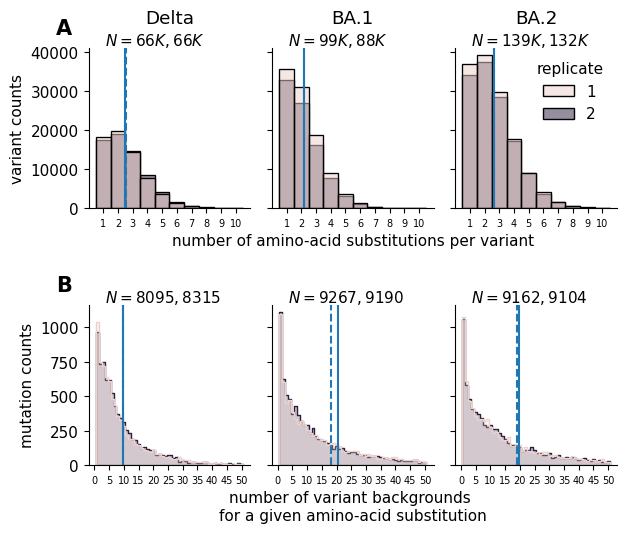

In [177]:
saveas = f"raw_data_summary_barcodes_backgrounds_hist"
logscale=False
fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.5])

condition_title = {
    "Delta":"Delta",
    "Omicron_BA1" : "BA.1",
    "Omicron_BA2" : "BA.2"
}

row = 0
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    iter_ax = ax[row, col]
    
    df = condition_df.query("aa_substitutions != ''")
    df = df.assign(
        num_muts = [
            len(aa_subs.split())
            for aa_subs in df.aa_substitutions
        ]
    )
    
    sns.histplot(df.query("num_muts <= 10"), x="num_muts", ax=iter_ax, hue="replicate", discrete=True)
    for rep, rep_df in df.groupby("replicate"):
        mean = rep_df['num_muts'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
    
    if logscale: iter_ax.set_yscale('log')
    if col != 2: 
        iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))//1000
    n_rep2 = len(df.query("replicate == 2"))//1000
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}K, {n_rep2}K$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    xscale = "number of amino-acid substitutions per variant" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"variant counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    iter_ax.set_xticks(
        [i+1 for i in range(10)],
        labels=[i+1 for i in range(10)], 
        ha="center",
        size=7,
        rotation=0
    )
    sns.despine(ax=iter_ax)
    iter_ax.set_title(condition_title[condition], y=1.10)

row = 1
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    iter_ax = ax[row, col]
    df = pd.DataFrame()
    for rep, rep_df in condition_df.groupby("replicate"):
        
        times_seen = (
            rep_df["aa_substitutions"].str.split().explode().value_counts()
        )
        if (times_seen == times_seen.astype(int)).all():
            times_seen = times_seen.astype(int)
        times_seen = pd.DataFrame(times_seen)
        times_seen.index.name = f"mutation"
        df = pd.concat([df, times_seen.assign(replicate=rep).reset_index()])

    sns.histplot(
        df.query("count <= 50"), 
        x="count", 
        ax=iter_ax, 
        element='step', 
        hue="replicate", 
        discrete=True
    )
    
    for rep, rep_df in df.groupby("replicate"):
        mean = rep_df['count'].mean()
        iter_ax.axvline(mean, linestyle=("-" if rep == 1 else "--"))
        
    iter_ax.get_legend().remove()
    n_rep1 = len(df.query("replicate == 1"))
    n_rep2 = len(df.query("replicate == 2"))
    iter_ax.text(
        0.1, 1.1, 
        f"$N={n_rep1}, {n_rep2}$", 
        ha="left", va="top", 
        transform=iter_ax.transAxes
    )
    
    xscale = "number of variant backgrounds \nfor a given amino-acid substitution" if col == 1 else ""
    iter_ax.set_xlabel(xscale)
    
    ylabel = f"mutation counts" if col == 0 else ""
    iter_ax.set_ylabel(ylabel)
    
    xticks = [i for i in range(0, 51) if i % 5 == 0]
    iter_ax.set_xticks(
        xticks,
        labels=xticks, 
        ha="center",
        size=7,
        rotation=0
    )
    
    sns.despine(ax=iter_ax)

plt.tight_layout()

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

fig.subplots_adjust(hspace=.6)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Functional score distributions

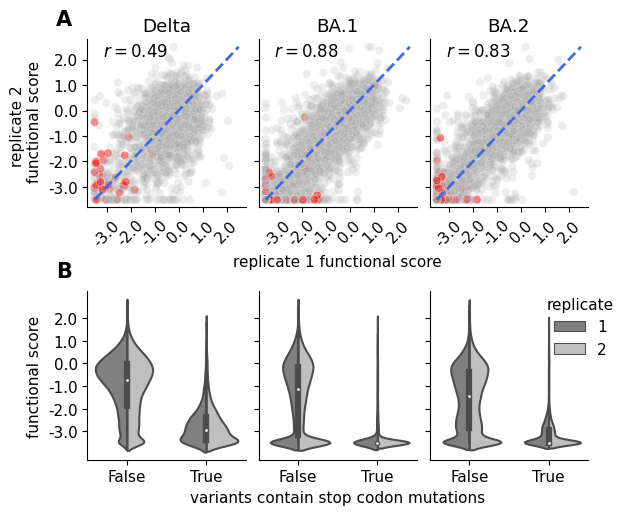

In [113]:
saveas = "replicate_functional_score_correlation_scatter"
pal = sns.color_palette('tab20')

fig, ax = plt.subplots(2,3, sharex="row", sharey="row", figsize=[6.4, 5.3])
collapsed_bc_df = func_score_df.groupby(
    ["replicate", "condition", "aa_substitutions"]
).aggregate("mean").reset_index()
collapsed_bc_df = collapsed_bc_df.assign(
    is_stop=[True if "*" in aasubs else False for aasubs in collapsed_bc_df.aa_substitutions]
)

is_stop_alpha_dict = {
    True : 0.5,
    False : 0.2
}

lim = [-3.8, 2.8]
ticks = np.linspace(-3, 2, 6)
for col, (condition, condition_df) in enumerate(collapsed_bc_df.groupby("condition")):
    
    row = 0
    iter_ax = ax[row, col]
    
    df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        [
            rep_df.rename({"func_score":f"rep_{rep}_func_score"}, axis=1).set_index("aa_substitutions")
            for rep, rep_df in condition_df.groupby("replicate") 
        ],
    )
    
    df = df.assign(
        is_stop=[True if "*" in aasubs else False for aasubs in df.index.values]
    )
    df = df.assign(
        n_subs=[len(aasubs.split()) for aasubs in df.index.values]
    )
    
    alpha = [is_stop_alpha_dict[istp] for istp in df.is_stop]
    sns.scatterplot(
        df, 
        x="rep_1_func_score", 
        y="rep_2_func_score", 
        ax =iter_ax,
        alpha=alpha,
        hue="is_stop",
        hue_order=[False, True],
        palette=["darkgrey", "red"]
    )
    
    iter_ax.plot([-3.5, 2.5], [-3.5, 2.5], "--", lw=2, c="royalblue")
    
    iter_ax.set_ylim(lim)
    iter_ax.set_xlim(lim)
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)
    iter_ax.set_xticks(ticks, labels=ticks, rotation=45)
    
    corr = pearsonr(df["rep_1_func_score"], df["rep_2_func_score"])[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.1, 0.9), 
        xycoords="axes fraction", 
        fontsize=12
    )
    iter_ax.set_title(condition)
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    row = 1
    iter_ax = ax[row, col]
    sns.violinplot(
        condition_df,
        x="is_stop",
        y="func_score",
        hue="replicate",
        split=True,
        palette=["0.5", "0.75"],
        ax=iter_ax
    )
    
    sns.despine(ax=iter_ax)
    if col != 2:
        iter_ax.get_legend().remove()
    else:
        iter_ax.legend(bbox_to_anchor = (1.25, 1.05), title="replicate")
    if col == 0:
        iter_ax.set_yticks(ticks, labels=ticks)

ax[0,0].set_xlabel("")
ax[0,0].set_ylabel("replicate 2 \n functional score")

ax[0,1].set_xlabel("replicate 1 functional score")
ax[0,1].set_title("BA.1")
ax[0,2].set_xlabel("")
ax[0,2].set_title("BA.2")

ax[1,0].set_xlabel("")
ax[1,0].set_ylabel("functional score")

ax[1,1].set_xlabel("variants contain stop codon mutations")
ax[1,2].set_xlabel("")
ax[1,2].set_ylabel("")
ax[1,1].set_ylabel("")

ax[0,0].text(
    -0.1, 1.06, 
    f"A", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.06, 
    f"B", 
    ha="right", va="bottom", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)

# fig.suptitle("Variant Functional Score \nReplicate Correlation")
plt.tight_layout()
fig.subplots_adjust(wspace=0.08, hspace = 0.5)
fig.savefig(f"{OUTDIR}/{saveas}.pdf")
fig.savefig(f"{OUTDIR}/{saveas}.png")
plt.show()

## Initialize replicate `multidms.Data` objects for fitting

next, we instaciate the two replicate objects, each with one set of three experiments across the three homologs 

In [114]:
datasets = []
for res, fsdf in func_score_df.groupby("replicate"):       

    start = time.time()

    # initialize data object
    data = multidms.Data(
        fsdf,
        collapse_identical_variants="mean",
        alphabet=multidms.AAS_WITHSTOP_WITHGAP,
        reference="Omicron_BA1",
        assert_site_integrity=False,
        verbose=True,
        nb_workers=8 
    )

    end = time.time()
    prep_time = round(end-start)
    print(f"Finished, time: {prep_time}")

    datasets.append(data)

inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/70597 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
unknown cond wildtype at sites: [144, 143, 69, 145, 70, 211, 25, 26, 24, 157, 158, 898],
dropping: 10983 variantswhich have mutations at those sites.
invalid non-identical-sites: [371], dropping 2041 variants
Converting mutations for Delta
Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2
Finished, time: 85
inferring site map for Delta


  0%|          | 0/29158 [00:00<?, ?it/s]

inferring site map for Omicron_BA1


  0%|          | 0/62129 [00:00<?, ?it/s]

inferring site map for Omicron_BA2


  0%|          | 0/57719 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
unknown cond wildtype at sites: [145, 70, 144, 143, 69, 211, 422, 26, 24, 25, 157, 158],
dropping: 10129 variantswhich have mutations at those sites.
invalid non-identical-sites: [371], dropping 1873 variants
Converting mutations for Delta
Converting mutations for Omicron_BA1
is reference, skipping
Converting mutations for Omicron_BA2
Finished, time: 83


**Change the datasets colors - the only mutible thing about `Data` Objects**

In [ ]:
import matplotlib.colors as colors

palette = [
    '#F97306',#, '#FFA500',
    '#BFBFBF',#,'#404040', 
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
# cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}
cc = {con:col for con, col in zip(conditions, palette)}


for data in datasets:
    data.condition_colors = cc

In [ ]:
datasets

In [ ]:
# models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))

In [ ]:
models = pd.DataFrame()

In [ ]:
# models = pd.DataFrame()
fit_iter = 0
shrinkage_sweep = [0.0, 1e-06, 1e-05, 2e-05, 5e-05, 0.0001, 0.0005, 0.001]
# shrinkage_sweep = [2e-05, 5e-05]

for lasso in shrinkage_sweep:
    for replicate, dataset in enumerate(datasets):

        fit_params = {
            'init_beta_naught' : 0.0,
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Identity",
            'warmup_beta':False,
            'gamma_corrected':False,
            'alpha_d': True,
            'scale_coeff_lasso_shift':lasso,
            'scale_coeff_ridge_beta':0,
            'scale_coeff_ridge_shift':0,
            'scale_coeff_ridge_gamma':1e-3,
            'scale_coeff_ridge_ch':1e-3,
            'tol':1e-4,
            'save_model_at':[30000],
            'num_training_steps': 30,
            'iterations_per_step':1000
        }
        
        start_t = time.time()
        model = multidms.utils.fit_wrapper(dataset, **fit_params)
        model['replicate'] = replicate
        models = pd.concat([models, model], ignore_index=True)
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/10! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        

    pickle.dump(models, open(f"{OUTDIR}/models.pkl", "wb"))

In [115]:
# extry point
# models = pickle.load(open(f"{OUTDIR}/models.pkl", "rb"))

In [165]:
models

dataset huber_scale_huber  \
0   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
1   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
2   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
3   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
4   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
5   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
6   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
7   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
8   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
9   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
10  <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
11  <multidms.data.Data object at 0x7fc9a8788f90>                 1   
12  <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
13  <multidms.data.Data object at 0x7fc9a8788f90>                 1   
14  <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
15  <multidms.data.Data object at 0x7fc9a8788f90>                 1   

   scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
0                      0.0                      0                       0   
1                      0.0                      0                       0   
2                 0.000001                      0                       0   
3                 0.000001                      0                       0   
4                  0.00001                      0                       0   
5                  0.00001                      0                       0   
6                  0.00002                      0                       0   
7                  0.00002                      0                       0   
8                  0.00005                      0                       0   
9                  0.00005                      0                       0   
10                  0.0001                      0                       0   
11                  0.0001                      0                       0   
12                  0.0005                      0                       0   
13                  0.0005                      0                       0   
14                   0.001                      0                       0   
15                   0.001                      0                       0   

   scale_coeff_ridge_gamma scale_coeff_ridge_ch data_idx epistatic_model  \
0                    0.001                0.001        0         Sigmoid   
1                    0.001                0.001        0         Sigmoid   
2                    0.001                0.001        0         Sigmoid   
3                    0.001                0.001        0         Sigmoid   
4                    0.001                0.001        0         Sigmoid   
5                    0.001                0.001        0         Sigmoid   
6                    0.001                0.001        0         Sigmoid   
7                    0.001                0.001        0         Sigmoid   
8                    0.001                0.001        0         Sigmoid   
9                    0.001                0.001        0         Sigmoid   
10                   0.001                0.001        0         Sigmoid   
11                   0.001                0.001        0         Sigmoid   
12                   0.001                0.001        0         Sigmoid   
13                   0.001                0.001        0         Sigmoid   
14                   0.001                0.001        0         Sigmoid   
15                   0.001                0.001        0         Sigmoid   

   output_activation  ... init_beta_naught warmup_beta     tol  \
0           Identity  ...              0.0       False  0.0001   
1           Identity  ...              0.0       False  0.0001   
2           Identity  ...        

## Convergence

In [117]:
model_name = "model_30000"
times_seen_threshold = 1
chosen_lasso_strength = 5e-5

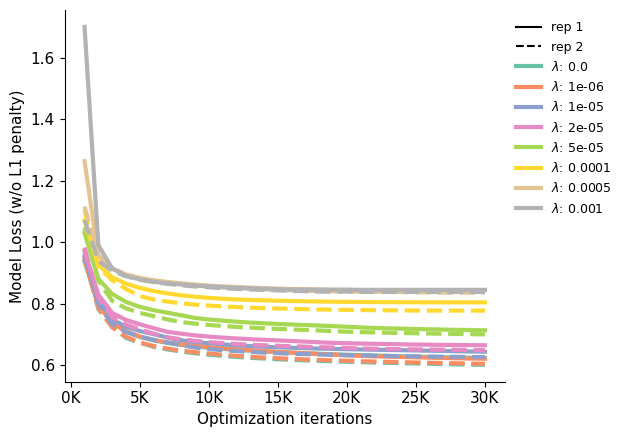

In [118]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )

ticks = range(0, 30001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)
ax.set_ylim()
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shrinkage Analysis

In [119]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    mut_df.rename(
        {
            bc : f"{bc}_Omicron_BA1"
            for bc in mut_df.columns
            if "beta" in bc
        }, 
        axis=1, 
        inplace=True
    )

    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if ("_shift_" in col or "beta" in col) and "avg" not in col
        ],
        value_name="S"
    )
    
    mut_df = mut_df.assign(
        scale_coeff_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "stop" if "*" in mut else "nonsynonymous"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df

mutation         S scale_coeff_lasso          sense    condition  \
0           M1I -2.931893               0.0  nonsynonymous  Omicron_BA1   
1           F2I  0.360803               0.0  nonsynonymous  Omicron_BA1   
2           F2L  0.496981               0.0  nonsynonymous  Omicron_BA1   
3           F2S  0.260409               0.0  nonsynonymous  Omicron_BA1   
4           F2V  0.913369               0.0  nonsynonymous  Omicron_BA1   
...         ...       ...               ...            ...          ...   
154915   S1252T -0.000000             0.001  nonsynonymous  Omicron_BA2   
154916   S1252V -0.000000             0.001  nonsynonymous  Omicron_BA2   
154917   S1252W -0.000000             0.001  nonsynonymous  Omicron_BA2   
154918   S1252Y -0.000000             0.001  nonsynonymous  Omicron_BA2   
154919   S1252* -0.000000             0.001           stop  Omicron_BA2   

        replicate  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
154915          1  
154916          1  
154917          1  
154918          1  
154919          1  

[308184 rows x 6 columns]

In [120]:
def loss(model, condition):
    kwargs = {
        'scale_coeff_ridge_beta': 0.,
        'scale_coeff_ridge_shift': 0.,
        'scale_coeff_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "nonsynonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference:
            

            if np.all(muts_df_inner[f"0_beta"] <= 0.05) or np.all(muts_df_inner[f"1_beta"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_beta"], muts_df_inner[f"1_beta"])
                r = corr[0]
                interval = corr.confidence_interval()
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                    tuple[(interval.low, interval.high)]
                )

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_beta", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_beta"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            

        else:
            if np.all(muts_df_inner[f"0_shift_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_shift_{cond}"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_shift_{cond}"], muts_df_inner[f"1_shift_{cond}"])
                r = corr[0]
                interval = corr.confidence_interval()
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                    tuple[(interval.low, interval.high)]
                )

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_shift_{cond}", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_shift_{cond}"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    # plot loss 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
#             if cond == model.data.reference: continue
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

lasso  Delta-replicate-correlation  \
0     0.0                     0.546623   
1   1e-06                     0.559217   
2   1e-05                     0.657265   
3   2e-05                     0.687850   
4   5e-05                     0.697929   
5  0.0001                     0.672427   
6  0.0005                          NaN   
7   0.001                          NaN   

            Delta-replicate-correlation-interval  Delta-0-stop-sparsity  \
0  tuple[0.5285300739174201, 0.5642202029094278]               0.000000   
1   tuple[0.541477064343816, 0.5764586819725837]               1.604278   
2  tuple[0.6425670830294457, 0.6714800035366452]              43.315508   
3  tuple[0.6742050390522982, 0.7010245701790201]              80.748663   
4   tuple[0.6846425398502697, 0.710751298214255]              97.860963   
5  tuple[0.6582447482166089, 0.6861318225000076]             100.000000   
6                                            NaN             100.000000   
7                                            NaN             100.000000   

   Delta-0-nonsynonymous-sparsity  Delta-1-stop-sparsity  \
0                        0.000000               0.000000   
1                        1.064688               3.791469   
2                       14.502339              44.075829   
3                       25.520245              77.725118   
4                       48.346508              96.682464   
5                       92.063236             100.000000   
6                      100.000000             100.000000   
7                      100.000000             100.000000   

   Delta-1-nonsynonymous-sparsity  Omicron_BA1-replicate-correlation  \
0                        0.000000                           0.927772   
1                        1.153107                           0.928947   
2                       17.120436                           0.929414   
3                       28.251121                           0.924364   
4                       50.448430                           0.913997   
5                       87.347854                           0.913367   
6                      100.000000                           0.909687   
7                      100.000000                           0.909437   

      Omicron_BA1-replicate-correlation-interval  Omicron_BA1-0-stop-sparsity  \
0   tuple[0.9241433549073178, 0.931233000681446]                          0.0   
1   tuple[0.9253753416810845, 0.932353892628659]                          0.0   
2  tuple[0.9258647703528898, 0.9327991496737005]                          0.0   
3  tuple[0.9205716220974351, 0.9279825917196133]                          0.0   
4   tuple[0.9097086076796567, 0.918089910696626]                          0.0   
5  tuple[0.9090488517826953, 0.9174887506452843]                          0.0   
6   tuple[0.9051948163995132, 0.913976238577383]                          0.0   
7   tuple[0.9049329181096166, 0.913737500502333]                          0.0   

   ...  Omicron_BA2-0-stop-sparsity  Omicron_BA2-0-nonsynonymous-sparsity  \
0  ...                     0.000000                              0.000000   
1  ...                     4.278075                              2.274560   
2  ...                    56.684492                             22.471366   
3  ...                    87.700535                             39.425714   
4  ...                    99.465241                             64.445878   
5  ...                   100.000000                             93.982900   
6  ...                   100.000000                             99.983868   
7  ...                   100.000000                            100.000000   

   Omicron_BA2-1-stop-sparsity  Omicron_BA2-1-nonsynonymous-sparsity  \
0                     0.000000                              0.000000   
1                     3.317536                              2.274183   
2                    59.715640                             23.398463   
3                    91.943128                 

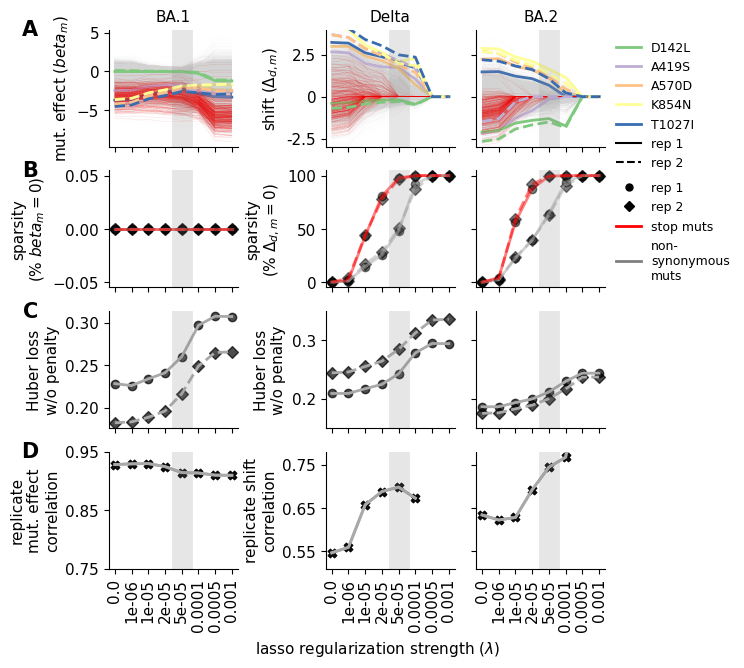

In [124]:
saveas="shrinkage_analysis_trace_plots_beta"
fig, ax = plt.subplots(
    4,4, 
    figsize=[6.4,7],
    sharex=True, 
    gridspec_kw={
        'width_ratios': [1,0.35,1,1]
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Omicron_BA1" : 0,
    "Delta" : 2,
    "Omicron_BA2" : 3
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.1
}

sense_alpha = {
    "nonsynonymous" : 0.1,
    "stop" : 0.5
}

model_choice = chosen_lasso_strength
model_line_kwargs = {
    "linewidth" : 15,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    # plot nonsynonymous, non validated
    for mut, trace_df in df.query(
        "sense == 'nonsynonymous' & not mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_alpha['nonsynonymous'],
            alpha=sense_alpha['nonsynonymous'],
            color="lightgrey"
        )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)



ax[0, 0].set_title(r"BA.1", size=11)
ax[0, 2].set_title("Delta", size=11)
ax[0, 3].set_title("BA.2", size=11)

ax[0, 1].set_visible(False)
ax[1, 1].set_visible(False)
ax[2, 1].set_visible(False)
ax[3, 1].set_visible(False)

ax[0, 0].set_ylabel("mut. effect ($beta_{m}$)", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $beta_{m} = 0$)", size=11)
# ax[2, 0].set_ylabel("condition\n train data loss \n$L_{Huber_{\sigma=1}}^{d}$ w/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[2, 0].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[3, 0].set_ylabel("$r(beta_{m}^{rep1},beta_{m}^{rep2})$", size=11)
ax[3, 0].set_ylabel("replicate\nmut. effect\ncorrelation", size=11)

ax[0, 2].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 2].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
# ax[2, 2].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[2, 2].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)

# ax[3, 2].set_ylabel("$r(\Delta_{d,m}^{rep1},\Delta_{d,m}^{rep2})$", size=11)
ax[3, 2].set_ylabel("replicate shift\ncorrelation", size=11)

# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop muts')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='non-\nsynonymous\nmuts')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=90, ha='center')
ax[3,2].set_xticks(ax[3,2].get_xticks(), ax[3,2].get_xticklabels(), rotation=90, ha='center')
ax[3,3].set_xticks(ax[3,3].get_xticks(), ax[3,3].get_xticklabels(), rotation=90, ha='center')

ax[3,2].set_xlabel(f"lasso regularization strength ($\lambda$)")
ax[3,2].xaxis.set_label_coords(0.4, -0.6)

ax[0,0].text(
    -0.55, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.55, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)
ax[2,0].text(
    -0.55, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[2,0].transAxes
)
ax[3,0].text(
    -0.55, 1.00, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[3,0].transAxes
)

ax[0, 2].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
ax[0, 2].set_ylim([-3.0, 4])
ax[0, 3].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
ax[0, 3].set_ylim([-3.0, 4])
ax[0, 3].yaxis.set_tick_params(labelleft=False)

ax[1, 2].set_yticks([0, 50, 100], [0, 50, 100])
ax[1, 2].set_ylim([-5, 105])
ax[1, 3].set_yticks([0, 50, 100], [0, 50, 100])
ax[1, 3].set_ylim([-5, 105])
ax[1, 3].yaxis.set_tick_params(labelleft=False)

ax[2, 2].set_yticks([.1, .2, .3], [.1, .2, .3])
ax[2, 2].set_ylim([.15, .35])
ax[2, 3].set_yticks([.1, .2, .3], [.1, .2, .3])
ax[2, 3].set_ylim([.15, .35])
ax[2, 3].yaxis.set_tick_params(labelleft=False)

ax[3, 2].set_yticks([.55, .65, .75], [.55, .65, .75])
ax[3, 2].set_ylim([.51, .78])
ax[3, 3].set_yticks([.55, .65, .75], [.55, .65, .75])
ax[3, 3].set_ylim([.51, .78])
ax[3, 3].yaxis.set_tick_params(labelleft=False)

ax[3, 0].set_yticks([.75, .85, .95], [.75, .85, .95])

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Global epistasis fits

In [125]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
replicate_data = {}
for row_idx, replicate_row in chosen_replicate_models.iterrows():    
     
    model = replicate_row[model_name]
    df = model.variants_df
    xlb, xub = [-1, 1] + np.quantile(df.predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(df.func_score, [0.05, 1.0])
    additive_model_grid = np.linspace(xlb, xub, num=1000)
    params = model.get_condition_params(model.data.reference)
    latent_preds = model._model_components["g"](params["theta"], additive_model_grid)
    shape = (additive_model_grid, latent_preds)   
    
    replicate_data[replicate_row.replicate] = {
        "variants_df" : df,
        "wildtype_df" : model.wildtype_df,
        "epistasis_shape" : shape,
        "condition_colors" : model.data.condition_colors
    }

Delta predicted_latent       -0.401167
predicted_func_score    0.106257
Name: Delta, dtype: float64

Omicron_BA1 predicted_latent       -0.490138
predicted_func_score   -0.077229
Name: Omicron_BA1, dtype: float64

Omicron_BA2 predicted_latent       -0.466431
predicted_func_score   -0.028693
Name: Omicron_BA2, dtype: float64

Delta predicted_latent       -0.689833
predicted_func_score    0.043245
Name: Delta, dtype: float64

Omicron_BA1 predicted_latent       -0.753356
predicted_func_score   -0.100105
Name: Omicron_BA1, dtype: float64

Omicron_BA2 predicted_latent       -0.679855
predicted_func_score    0.066044
Name: Omicron_BA2, dtype: float64



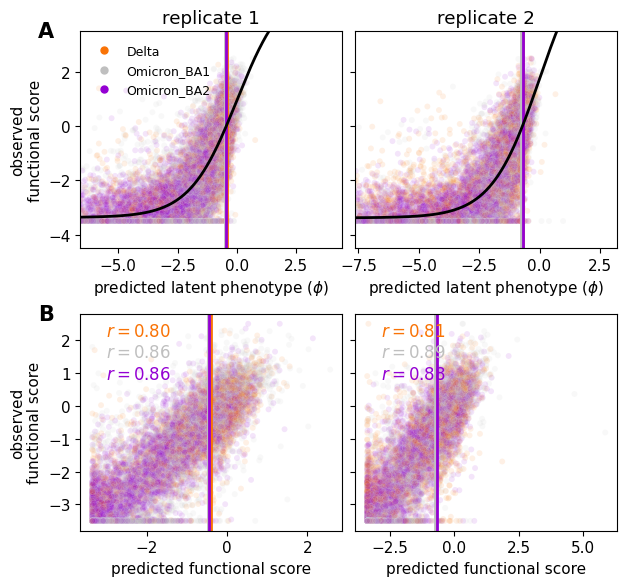

In [127]:
saveas="global_epistasis_and_prediction_correlations"
fig, ax = plt.subplots(2,2, figsize=[6.4,6], sharey='row')    

row=0
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.2),
        x="predicted_latent",
        y=f"func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1,
        lw=3
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        print(condition, values)
        print()
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    iter_ax.plot(*data["epistasis_shape"], color="k", lw=2)
    
    xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    ylb, yub = [-1, 1] + np.quantile(data["variants_df"].func_score, [0.05, 1.0])
    iter_ax.set_xlim([xlb, xub])
    iter_ax.set_ylim([ylb, yub])
    iter_ax.set_title(f"replicate {replicate+1}")
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted latent phenotype ($\phi$)")

row=1
for replicate, data in replicate_data.items():

    iter_ax = ax[row, replicate]
    sns.scatterplot(
        data=data["variants_df"].sample(frac=0.1),
        x="predicted_func_score",
        y=f"func_score",
        hue="condition",
        palette=model.data.condition_colors,
        ax=iter_ax,
        legend=False,
        size=5,
        alpha=0.1
    )
    
    for condition, values in data["wildtype_df"].iterrows():
        iter_ax.axvline(
            values.predicted_latent,
            label=condition,
            c=model.data.condition_colors[condition],
            lw=2,
        )
    
    # xlb, xub = [-1, 1] + np.quantile(data["variants_df"].predicted_latent, [0.05, 1.0])
    # ylb, yub = [-1, 1] + np.quantile(data["variants_df"].func_score, [0.05, 1.0])
    
    # iter_ax.plot([ylb, yub], [ylb, yub], "k--", lw=2)
    # iter_ax.set_xlim([-4, 3])
    # iter_ax.set_ylim([-4, 3])
    iter_ax.set_ylabel("observed\nfunctional score")
    iter_ax.set_xlabel("predicted functional score")

    start_y = 0.9
    for c, cdf in data["variants_df"].groupby("condition"):
        r = pearsonr(
            cdf["predicted_func_score"],
            cdf["func_score"]
        )[0]
        iter_ax.annotate(
            f"$r = {r:.2f}$",
            (0.1, start_y),
            xycoords="axes fraction",
            fontsize=12,
            c=model.data.condition_colors[c],
        )
        start_y += -0.1


elements = [
    mlines.Line2D([], [], color=color, marker='o', linestyle='None',markersize=5, label=condition)
    for condition, color in replicate_data[0]["condition_colors"].items()
]


ax[0, 0].legend(
    handles=elements, 
    bbox_to_anchor = (0., .99), 
    loc='upper left', 
    frameon=False, 
    fontsize=9
)
    
    
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)

ax[0,0].text(
    -0.1, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.1, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)


fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Percent Shifts Under X

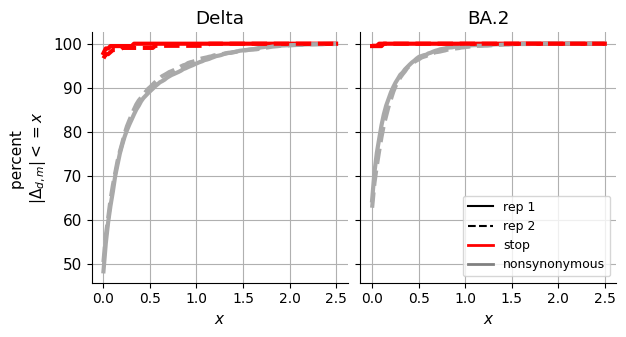

In [137]:
saveas = "percent_shifts_under_x_lineplot"
fig, ax = plt.subplots(1,2, figsize=[6.4,3.5], sharey='row')
tall_mut_df_chosen = tall_mut_df.query("scale_coeff_lasso == '5e-05' & condition != 'Omicron_BA1'")

condition_col = {
    "Delta" : 0,
    "Omicron_BA2" : 1
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

t_points = np.linspace(0, 2.5, 100)
def perc_abs_lte(x, t):
    abs_x = np.abs(x)
    return len(abs_x[abs_x<=t]) / len(x) #)*100

for (condition, replicate, sense), df in tall_mut_df_chosen.groupby(["condition", "replicate", "sense"]):
    iter_ax = ax[condition_col[condition]]
    lt_percentages = [perc_abs_lte(df["S"], t)*100 for t in t_points]
    iter_ax.plot(
        t_points, 
        lt_percentages,
        linestyle = replicate_line_style[replicate],
        color = sense_colors[sense],
        linewidth = 3
    )
    iter_ax.set_xticks(np.linspace(0,2.5,6),np.linspace(0,2.5,6), rotation=0, ha="center",size=10)
    sns.despine(ax=iter_ax)
    iter_ax.grid(visible=True)
    
ax[condition_col["Delta"]].set_title("Delta")
ax[condition_col["Omicron_BA2"]].set_title("BA.2")

ax[0].set_ylabel("percent \n$|\Delta_{d,m}| <= x$")
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='nonsynonymous')
ax[1].legend(
    handles=[black_line, black_dashed, red_line, grey_line], 
    bbox_to_anchor = (1, 0), 
    loc='lower right', 
    frameon=True, 
    fontsize=9
)

plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Correlation of BA2 and Delta Shifts

In [170]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = [
    "stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts
]

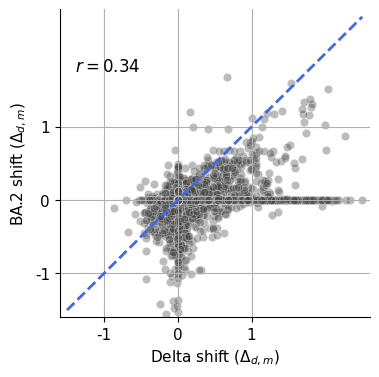

In [130]:
data = mut_df_replicates.dropna()
saveas="shift_corr_Delta_BA2"
fig, ax = plt.subplots(1,figsize=[4,4])
lim = [-1.6, 2.6]
ticks = range(-1, 2)
sns.scatterplot(
    data=data,
    x="avg_shift_Delta",
    y="avg_shift_Omicron_BA2",
#     hue = "sense",
    alpha = 0.35,
    ax=ax,
    c='0.25'
)
ax.plot()
ax.plot(
    [-1.5, 2.5], 
    [-1.5, 2.5],
    linestyle="--", 
    lw=2,
    c='royalblue'
)
corr = pearsonr(data["avg_shift_Delta"], data["avg_shift_Omicron_BA2"])[0]
ax.annotate(
    f"$r = {corr:.2f}$", 
    (0.05, 0.8), 
    xycoords="axes fraction", 
    fontsize=12
)
ax.set_ylim(lim)
ax.set_xlim(lim)
ax.set_yticks(ticks, labels=ticks)
ax.set_xticks(ticks, labels=ticks)
ax.set_ylabel("BA.2 shift ($\Delta_{d,m}$)")
ax.set_xlabel("Delta shift ($\Delta_{d,m}$)")
# ax.set(xticks=np.linspace(-1.5, 2.5, 5))
ax.grid()
sns.despine(ax=ax)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shifted mutations heat, and site map

In [131]:
# could add a 'min' column of 0, and 1
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts]

In [132]:
rename_omicron = {
    c:"_".join(c.split("_")[:2]+[c.split("_")[3]])
    for c in mut_df_replicates.columns if "Omicron" in c
}
mut_df_replicates.rename(rename_omicron, axis=1, inplace=True)

In [133]:
site_map = model.data.site_map.reset_index().rename(
    {"index":"sites", "Omicron_BA2": "BA2", "Omicron_BA1":"BA1"}, axis=1
).set_index("sites")

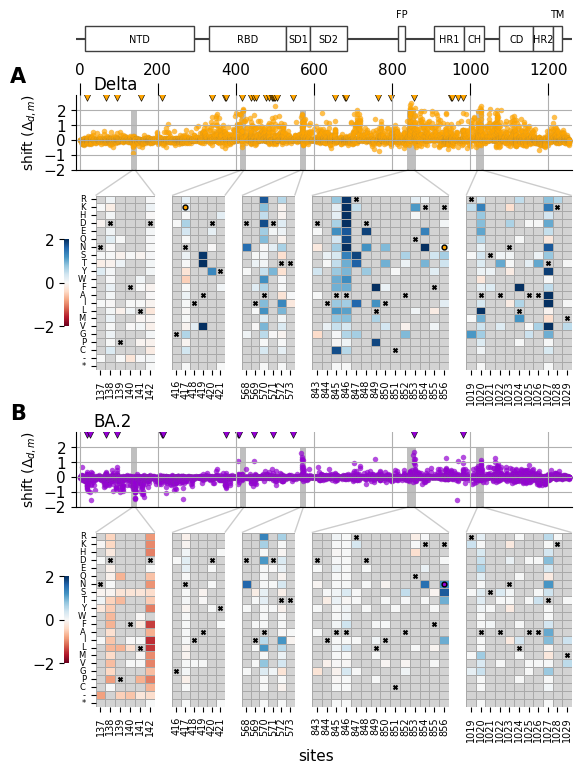

In [134]:
saveas = "shift_by_site_heatmap_zoom"

site_ranges = {
    "zoom1" : [137, 142],
    "zoom2" : [416, 421],
    "zoom3" : [568, 573],
    "zoom4" : [843, 856],
    "zoom5" : [1019, 1029]
}

# heatmap ax width ratios
width_ratios = [(end-start) for key, (start, end) in site_ranges.items()]

# make the first one a little bigger for the color bar
width_ratios[0] += width_ratios[0] * 0.5


# Plot domain architecture in primary sequence
# based on structure papers (Gobeil et al., 2022, Molecular Cell)
# (Duan et al., 2020, Frotiers in Immunology)
domain_dict = {
    'NTD' : [13, 293],
    'RBD' : [330, 528],
    'SD1' : [528, 590],
    'SD2' : [590, 685],
    'FP' : [815, 834],
    'HR1' : [907, 985],
    'CH' : [985, 1035],
    'CD' : [1075, 1162],
    'HR2' : [1162, 1211],
    'TM' : [1211, 1234],
}

sort_order = [
    "R","K","H","D","E","Q","N","S",
    "T","Y","W","F","A","I","L","M",
    "V","G","P","C","-","*",
]

fig = plt.figure( figsize=[6.4, 9])
axs = fig.subplot_mosaic(
    [
        ["Annotation"]*5,
        ["Delta"]*5,
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        [f"{k}_Delta" for k in list(site_ranges.keys())],
        ["."]*5,
        ["BA2"]*5,
        [f"{k}_BA2" for k in list(site_ranges.keys())],
        [f"{k}_BA2" for k in list(site_ranges.keys())]
    ],
    
    height_ratios=[
        1.5, 
        2, 
        2, 
        2,
        0.3,
        2,
        2, 
        2
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
    width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)

# derived from
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/axes_zoom_effect.html
def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
            "clip_on": False,
        }

    c1 = BboxConnector(
        bbox1, bbox2, loc1=loc1a, loc2=loc2a, clip_on=False, **prop_lines)
    c2 = BboxConnector(
        bbox1, bbox2, loc1=loc1b, loc2=loc2b, clip_on=False, **prop_lines)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           clip_on=False,
                           **prop_patches)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect03(ax1, ax2, xmin, xmax, **kwargs):

    mybbox1 = ax1.bbox
    
    bbox = Bbox.from_extents(xmin, 0, xmax, 1)
    mybbox2 = TransformedBbox(bbox, ax2.get_xaxis_transform())

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=2, loc2a=3, loc1b=1, loc2b=4,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

#############
# sitewise
#############


pal = sns.color_palette('colorblind')
cs = ['darkviolet', 'orange']
cs = {
    'BA2' : 'darkviolet', 
    'Delta' : 'orange'
}


# Plot per-site metric
metric_prefix = 'max_abs_shift_' # 'delta_bind_S_' # 
# metric_prefix = 'sumdS_' # 'delta_bind_S_' # 
for (i, homolog) in enumerate(['BA2', 'Delta']):
    
#     sns.scatterplot(
#         x='sites', 
#         y=f'{metric_prefix}{homolog}',
#         data=shifts_by_site, 
#         s=15,
#         ax=axs[homolog], 
#         color=cs[homolog],
#         label=""
#     )

    sns.scatterplot(
        x='sites', 
        y=f'avg_shift_{homolog}',
        data=mut_df_replicates, 
        s=15,
        alpha=0.7,
        edgecolor="grey",
        linewidth=0.05,
        ax=axs[homolog], 
        color=cs[homolog],
        label=""
    )
    
#     nis = shifts_by_site.query(f"not is_{homolog}_wt")
    nis = site_map.query(f"{homolog} != BA1")
    sns.scatterplot(
        x='sites', 
        y=np.repeat(2.9, len(nis)),
        data=nis, 
        s=30,
        ax=axs[homolog],
        marker='v',
        facecolor=cs[homolog], 
        edgecolor="k"
    )

    
    
#     axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].grid()
    axs[homolog].set(
        xlim=[-10,1260],
        ylim=[-2, 3],
        yticks=[-2, -1, 0, 1, 2],
#         ylabel=homolog,/
    )
    sns.despine(ax=axs[homolog])
    
    axs[homolog].tick_params(
        axis='x', 
        bottom=False,
        labelbottom=False,
        labeltop=True if homolog == "Delta" else False,
        top=True if homolog == "Delta" else False,
        size=9
    )
    axs[homolog].set_xlabel(None)
#     axs[homolog].set_ylabel("max($|S_{m \in site}|$)", size=10)
    axs[homolog].set_ylabel('shift ($\Delta_{d,m}$)', size=10)


axs["BA2"]._shared_axes['x'].join(axs["BA2"], axs["Delta"])

plot_rectangles = True
for zoom, site_range in site_ranges.items():
    if not plot_rectangles:
        continue
    (site_i, site_j) = site_range
    for (i, homolog) in enumerate(['BA2', 'Delta']):
        rect = patches.Rectangle(
            (site_i-5, -2), site_j-site_i+11, 4,
            edgecolor='none', facecolor='0.75', zorder=0
        )
        axs[homolog].add_patch(rect)
        
        
#############
# Annotation
#############

for (domain, (start, end)) in domain_dict.items():
    rectangle = patches.Rectangle((start, 1), end-start, 2, edgecolor='0.25', facecolor='white')
    axs["Annotation"].add_patch(rectangle)
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry - 0.05 + rectangle.get_height()/2.0
    if domain in ['FP', 'TM']:
        cy += 2
    axs["Annotation"].annotate(
        domain, (cx, cy), color='black', ha='center', va='center',
        fontsize=7
    )

axs["Annotation"].set(ylim=[-0.5,4], yticks=[])
sns.despine(left=True, bottom=True, ax=axs["Annotation"])

axs["Annotation"].sharex(axs["BA2"])
axs["Annotation"].axhline(2, c='0.25', zorder=0)
axs["Annotation"].xaxis.set_tick_params(which='both', bottom=False, labelbottom=False, labeltop=False)

#############
# Heatmap
#############

for (i, homolog) in enumerate(['Delta', 'BA2']):
    
    df_shifts_wide = mut_df_replicates.pivot(
        index='muts', 
        columns='sites', 
        values=f'avg_shift_{homolog}'
    ).loc[sort_order, :]

    for zoom, (start, end) in site_ranges.items():
        
        iter_ax = axs[f"{zoom}_{homolog}"]
        iter_ax.set_facecolor("lightgrey")
        sites = [s for s in list(range(start, end+1)) if s in df_shifts_wide.columns]
        
        sns.heatmap(
            df_shifts_wide.loc[:, sites], 
            cbar=True if zoom == "zoom1" else False,
            cbar_kws={
                "shrink": 0.5, 
                "location":'left',
                'anchor': (-1.5, 0.5),
                'label' : None
            },
            ax = iter_ax,
            linewidth=.5, 
            linecolor="darkgrey",
            center=0,
            cmap='RdBu',
            vmin=-2.0,
            vmax=2.0,
            xticklabels=False,
            yticklabels=False,
        )

        for i, site in enumerate(sites):
            for j, mut in enumerate(sort_order):
                
                is_ref_wt = True if mut == site_map.loc[site,"BA1"] else False
                if is_ref_wt:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="x", 
                        s=8, 
                        c="black"
                    )
#                 hom = homolog if homolog == "Delta" else "Omicron_BA2"
                is_nis = (
                    True 
                    if mut ==  site_map.loc[site,homolog] and
                    mut !=  site_map.loc[site,"BA1"]
                    else False
                )
                
                if is_nis:
                    iter_ax.scatter(
                        [i+0.5], 
                        [j+0.5], 
                        marker="o", 
                        s=12, 
                        facecolors=cs[homolog],
                        edgecolors="black"
                    )

        if zoom != "zoom1":
            axs[f"{zoom}_{homolog}"].tick_params(axis='y', left=False, labelleft=False)
            sns.despine(left=True, bottom=True, ax=axs[f"{zoom}_{homolog}"])  
        else:
            axs[f"{zoom}_{homolog}"].set_yticks(
                [s+0.5 for s in range(len(sort_order))],
                labels=sort_order, 
                va="center",
                size=6
            )
            
        axs[f"{zoom}_{homolog}"].set_ylabel(None)
            
        if homolog != "Delta":
#             axs[f"{zoom}_{homolog}"].tick_params(axis='x', bottom=False, labelbottom=False) 
#         else:
            axs[f"{zoom}_{homolog}"].sharex(axs[f"{zoom}_Delta"])
        axs[f"{zoom}_{homolog}"].set_xticks(
            [s+0.5 for s in range(len(sites))],
             labels=sites, 
             ha="center",
            rotation=90,
            size=7
        )
        axs[f"{zoom}_{homolog}"].set_xlabel(None)

for zoom, (start, end) in site_ranges.items():
    for homolog in ['Delta', 'BA2']:
        zoom_effect03(axs[f"{zoom}_{homolog}"], axs[homolog], start, end, alpha= 0.2)

fig.text(
    0.5, 0.05, 'sites',
    ha='center'
)

axs["Delta"].text(
    -0.1, 1.25, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["Delta"].transAxes
)
axs["Delta"].text(
    0.035, 1.15, 
    f"Delta", 
    ha="left", va="center", 
    size=12,
    transform=axs["Delta"].transAxes
)

axs["BA2"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["BA2"].transAxes
)
axs["BA2"].text(
    0.035, 1.15, 
    f"BA.2", 
    ha="left", va="center", 
    size=12,
    transform=axs["BA2"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Interactive altair chart

In [135]:
# %reload_ext autoreload
# %autoreload 2
# import multidms

In [138]:
chart = multidms.plot.mut_shift_plot(
    {
        f"rep_{row.replicate}":row[model_name] 
        for idx, row in chosen_replicate_models.iterrows()
    },
    include_beta = False,
    times_seen_threshold=times_seen_threshold
)
chart.save(f"{OUTDIR}/interactive_chart_wo_beta.html")
chart

alt.VConcatChart(...)

## Validation mutations

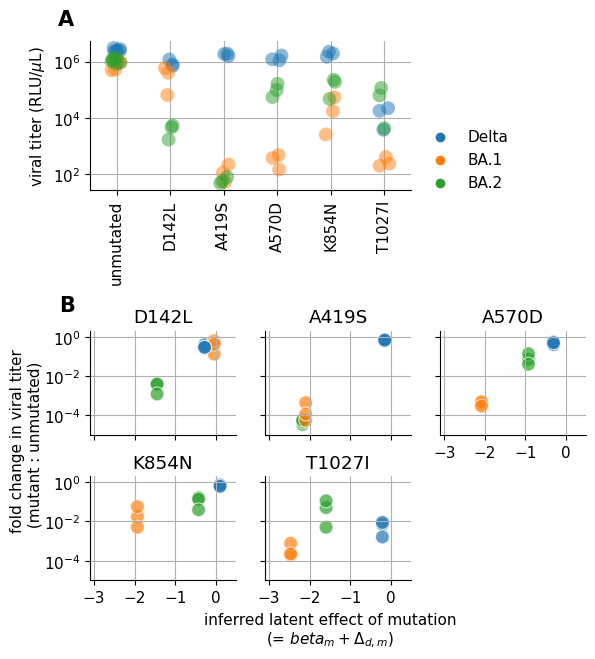

In [139]:
saveas="validation_titer_fold_change"

row1 = ['titer', 'titer', '.']
row2 = ['D142L', 'A419S', 'A570D'] 
row3 = ['K854N', 'T1027I', 'legend']
empty_row = ["."] * 3

fig = plt.figure( figsize=[6.4, 7])
axs = fig.subplot_mosaic(
    [row1, empty_row, row2, row3],
    height_ratios=[
        1, 0.39, 0.7, 0.7
    ],
    empty_sentinel=".",
    # set the width ratios between the columns
#     width_ratios=width_ratios,
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 0.4,
    }
)


#############
# TITERS
#############

# Read in data
titers_df = pd.read_csv('../data/viral_titers.csv')
titers_df.rename(
    columns={'RLUperuL':'titer', 'background':'homolog'},
    inplace=True
)

# Add a column giving the replicate and mutation
titers_df['replicate'] = titers_df['virus'].apply(lambda x: x[-1])
titers_df['mutation'] = titers_df['virus'].str.extract(r'_(\S+)_')
titers_df['mutation'].fillna('unmutated', inplace=True)
titers_df['mutation'].replace('142L', 'D142L', inplace=True)

# Plot data for a given mutation
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
#mutation = 'A570D'
homologs = ['Delta', 'BA.1', 'BA.2']
replicates = ['1', '2', '3']
# plt.figure(figsize=[7,4])
xticklabels = ['unmutated'] + validation_mutations
pal = sns.color_palette('colorblind')
hex_codes = pal.as_hex()
for (i, homolog) in enumerate(homologs):
    
    data = titers_df[(titers_df['homolog'] == homolog)]
    
    sns.stripplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels, s=10, alpha=0.5,
        hue='homolog', hue_order=['Delta', 'BA.1', 'BA.2'],
    )
    sns.boxplot(
        x='mutation', y='titer', data=data, ax=axs['titer'],
        order=xticklabels,
        showfliers=False, showbox=False, showcaps=False,
        medianprops={'visible': False}, #dict(color=hex_codes[i]),
        whiskerprops={'visible': False},
    )

handles, labels = axs['titer'].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axs['titer'].legend(by_label.values(), by_label.keys(), bbox_to_anchor=[1,0.5])

axs['titer'].set_yscale('log')
axs['titer'].set_yticks([1e2, 1e4, 1e6])
axs['titer'].set_xticklabels(axs['titer'].get_xticklabels(), rotation = 90)
axs['titer'].set_ylabel(r'viral titer (RLU/$\mu$L)')
axs['titer'].set_xlabel('')
axs['titer'].grid()
sns.despine(ax = axs['titer'])


#############
# FOLD CHANGE
#############

replicate_models = models.query("scale_coeff_lasso_shift == 5e-5")
fit_dict = {row.replicate:row[model_name] for _, row in replicate_models.iterrows()}
mut_df = multidms.utils.combine_replicate_muts(fit_dict, times_seen_threshold=3, how="inner")

rep0 = fit_dict[0]
for homolog in rep0.data.conditions:
    if homolog == rep0.data.reference:

        mut_df[f"beta_{homolog}"] = mut_df.avg_beta
    else:

        mut_df[f"beta_{homolog}"] = mut_df.avg_beta + mut_df[f"avg_shift_{homolog}"]

mut_df.reset_index(inplace=True)

# Read in data
val_df = pd.read_csv('../data/spike_validation_data.csv')

# Restructure the data
val_dict = {
    key : []
    for key in [
        'mutation', 'fold_change', 'homolog', 'replicate',
        'predicted_beta'
    ]
}
validation_mutations = ['D142L', 'A419S', 'A570D', 'K854N', 'T1027I']
for i, row in val_df.iterrows():
    for mutation in validation_mutations:
        homolog = row['background'].replace('.', '')
        homolog = "Omicron_" + homolog if "BA" in homolog else homolog

        val_dict['mutation'].append(mutation)
        val_dict['fold_change'].append(row[mutation])
        val_dict['homolog'].append(homolog)
        val_dict['replicate'].append(row['replicate'])

        predicted_beta = float(mut_df[
            mut_df['mutation'] == mutation
        ][f'beta_{homolog}'].values[0])
        val_dict['predicted_beta'].append(predicted_beta)

val_df = pd.DataFrame(val_dict)
val_df['site'] = val_df['mutation'].apply(lambda x: int(x[1:-1]))
val_df['homolog'].replace('Omicron_BA1', 'BA.1', inplace=True)
val_df['homolog'].replace('Omicron_BA2', 'BA.2', inplace=True)
val_df.sort_values('site', inplace=True)

for (i, mutation) in enumerate(validation_mutations):
    data = val_df[val_df['mutation'] == mutation]
    iter_ax = axs[mutation]
    sns.scatterplot(
        x='predicted_beta', y='fold_change', data=data,
        hue='homolog', ax=iter_ax, s=100, alpha=0.7,
        hue_order=['Delta', 'BA.1', 'BA.2']
    )
    iter_ax.set(
        title=mutation, xlabel='', ylabel='',
        yscale='log', ylim=[1e-5,2], yticks=[1, 1e-2, 1e-4],
        xlim=[-3.1, 0.5], xticks=[-3, -2, -1, 0]
    )
    iter_ax.grid()
    iter_ax.get_legend().remove()
    sns.despine(ax=iter_ax)
    
    if mutation in ['D142L', 'A419S']:
        iter_ax.tick_params(axis="x", labelbottom=False)
    
    if mutation not in ['D142L', 'K854N']:
        iter_ax.tick_params(axis="y", labelleft=False)

fig.text(
    0.5, 0.02, 'inferred latent effect of mutation\n(= $beta_m + \Delta_{d,m}$)',
    ha='center'
)
fig.text(
    0.000, 0.31, 'fold change in viral titer\n (mutant : unmutated)',
    va='center', rotation='vertical'
)
axs["legend"].set_axis_off()

axs["titer"].text(
    -0.05, 1.15, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["titer"].transAxes
)
axs["D142L"].text(
    -0.1, 1.25, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["D142L"].transAxes
)

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Comparison to single experiment fits

In [144]:
naive_models = pd.DataFrame()
for replicate, rep_fsdf in enumerate([fs_rep1, fs_rep2]):    
    
    for condition, condition_fsdf in rep_fsdf.groupby("condition"):

        start = time.time()

        # initialize data object
        data = multidms.Data(
            condition_fsdf,
            collapse_identical_variants="mean",
            alphabet=multidms.AAS_WITHSTOP_WITHGAP,
            reference=condition,
            assert_site_integrity=False,
            verbose=True,
            nb_workers=8 
        )
        data.condition_colors = cc        

        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")

        fit_params = {
#             'init_beta_naught' : 0.0,
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Identity",
            'warmup_beta':False,
            'gamma_corrected':False,
            'alpha_d':False,
#             'scale_coeff_lasso_shift':lasso, # no lasso needed! 
            'scale_coeff_ridge_beta':0,
            'scale_coeff_ridge_shift':0,
#             'scale_coeff_ridge_gamma':1e-3,
            'tol':1e-6,
            'save_model_at':[3000],
            'num_training_steps': 3,
            'iterations_per_step':10
        }
        
        start_t = time.time()
        model = multidms.utils.fit_wrapper(data, **fit_params)
        model['replicate'] = replicate
        model['condition'] = condition
        
        naive_models = pd.concat([naive_models, model], ignore_index=True)
        end_t = time.time()
        print(f"Done! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        
    pickle.dump(naive_models, open(f"{OUTDIR}/naive_models.pkl", "wb"))

inferring site map for Delta


  0%|          | 0/28515 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.
invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Delta
is reference, skipping
Finished, time: 27
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7fafe881b890>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 10,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/3,Loss

  0%|          | 0/70597 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.
invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA1
is reference, skipping
Finished, time: 31
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7faf3adf77d0>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 10,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/

  0%|          | 0/60397 [00:00<?, ?it/s]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
unknown cond wildtype at sites: [],
dropping: 0 variantswhich have mutations at those sites.
invalid non-identical-sites: [], dropping 0 variants
Converting mutations for Omicron_BA2
is reference, skipping
Finished, time: 31
running:
{'PRNGKey': 0,
 'alpha_d': False,
 'data_idx': 0,
 'dataset': <multidms.data.Data object at 0x7faa4aadf950>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': False,
 'huber_scale_huber': 1,
 'init_beta_naught': 0.0,
 'iterations_per_step': 10,
 'lock_beta': False,
 'lock_beta_naught': None,
 'num_training_steps': 3,
 'output_activation': 'Identity',
 'save_model_at': [3000],
 'scale_coeff_lasso_shift': 2e-05,
 'scale_coeff_ridge_beta': 0,
 'scale_coeff_ridge_ch': 0,
 'scale_coeff_ridge_gamma': 0,
 'scale_coeff_ridge_shift': 0,
 'step_loss': array([0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False}
training_step 0/

PicklingError: Can't pickle <class 'multidms.data.Data'>: it's not the same object as multidms.data.Data

In [ ]:
fit_dict = {f"{row.replicate}-{row.condition}":row.model_3000 for _, row in naive_models.iterrows()}
naive_mut_df = multidms.utils.combine_replicate_muts(fit_dict,how="inner",times_seen_threshold=3)
naive_mut_df

In [146]:
reference = "Omicron_BA1"
for i, condition in enumerate(["Delta", "Omicron_BA2"]): 
    for replicate in [0, 1]:
        reference_betas = naive_mut_df[f"{replicate}-{reference}_beta"]
        condition_betas = naive_mut_df[f"{replicate}-{condition}_beta"]
        naive_mut_df[f"{replicate}-{condition}_S"] = condition_betas - reference_betas
naive_mut_df

wts  sites muts  0-Delta_beta  0-Omicron_BA1_beta  \
mutation                                                     
M1I        M      1    I     -2.509346           -4.717206   
F2L        F      2    L      0.695470            0.402694   
V3A        V      3    A      0.110519            0.084359   
V3F        V      3    F     -0.621172           -0.675041   
V3G        V      3    G     -0.314578            0.006068   
...       ..    ...  ...           ...                 ...   
S1252R     S   1252    R      0.974202            0.232415   
S1252T     S   1252    T     -0.248973           -0.243054   
S1252V     S   1252    V      0.444267            0.370209   
S1252Y     S   1252    Y      0.864989            0.901391   
S1252*     S   1252    *     -0.225282           -0.218435   

          0-Omicron_BA2_beta  1-Delta_beta  1-Omicron_BA1_beta  \
mutation                                                         
M1I                -5.010637     -5.183149           -5.249604   
F2L                -0.385884      1.095539            0.673661   
V3A                -0.054072     -0.024772            0.028171   
V3F                -0.635997      0.185542           -0.548449   
V3G                 0.077659      0.897483            0.131336   
...                      ...           ...                 ...   
S1252R              0.592692      0.386746            0.573367   
S1252T             -0.571046     -0.714395           -0.347725   
S1252V              0.312138      0.068158            0.550719   
S1252Y              0.948030      0.693755            1.236366   
S1252*              0.029222     -0.017032            0.238550   

          1-Omicron_BA2_beta  avg_beta  ...  \
mutation                                ...   
M1I                -6.347744 -4.836281  ...   
F2L                 0.429805  0.485214  ...   
V3A                -0.113430  0.005129  ...   
V3F                -0.430014 -0.454189  ...   
V3G                 0.049073  0.141174  ...   
...                      ...       ...  ...   
S1252R              0.625938  0.564227  ...   
S1252T             -0.539059 -0.444042  ...   
S1252V              0.208330  0.325637  ...   
S1252Y              0.954969  0.933250  ...   
S1252*             -0.392688 -0.097611  ...   

          0-Omicron_BA1_predicted_func_score  \
mutation                                       
M1I                                -3.255797   
F2L                                 0.226371   
V3A                                 0.044802   
V3F                                -0.550415   
V3G                                -0.005961   
...                                      ...   
S1252R                              0.134122   
S1252T                             -0.184018   
S1252V                              0.209613   
S1252Y                              0.438276   
S1252*                             -0.165302   

          0-Omicron_BA2_predicted_func_score  1-Delta_predicted_func_score  \
mutation                                                                     
M1I                                -3.008744                     -2.841881   
F2L                                -0.206741                      0.020332   
V3A                                -0.049399                     -0.116768   
V3F                                -0.349809                     -0.079418   
V3G                                 0.003461                      0.005198   
...                                      ...                           ...   
S1252R                              0.164979                     -0.049676   
S1252T                             -0.310579                     -0.298070   
S1252V                              0.085326                     -0.099409   
S1252Y                              0.242081                     -0.013627   
S1252*                             -0.015374                     -0.115268   

          1-Omicron_BA1_predicted_func_score  \
mutation                                   

In [158]:
chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_lasso_strength")
mut_df_replicates = multidms.utils.combine_replicate_muts(
    {
        row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
    },
    times_seen_threshold=times_seen_threshold,
    how="inner"
)
mut_df_replicates["sense"] = ["stop" if mut == "*" else "nonsynonymous" for mut in mut_df_replicates.muts]

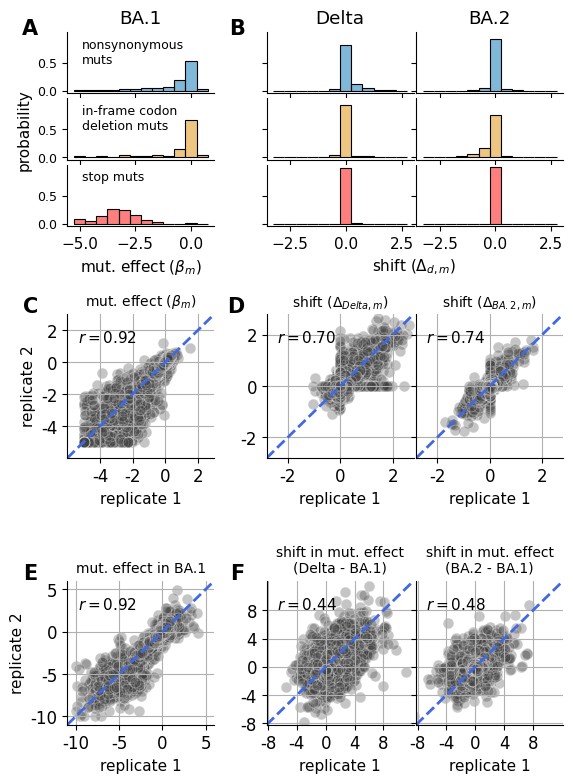

In [162]:
# data = mut_df_replicates.copy()
saveas="shift_distribution_correlation_naive"
pal = sns.color_palette('colorblind')
fig = plt.figure(figsize=[6.4, 9])

# the ratio of plot to divider between 
dist_sf = 3

# three rows of distributions
dist_rows = [[] for _ in range(3)]
for row, mut_type in enumerate(["m", "i", "n"]):
    dist_rows[row].extend([f"dist_{mut_type}_beta"]*dist_sf)
    dist_rows[row].append(".")
    for param in ["shift_Delta", "shift_Omicron_BA2"]:
        dist_rows[row].extend([f"dist_{mut_type}_{param}"]*dist_sf)

# empty space row
number_of_rows = len(dist_rows[0])
empty_row = ["."] * len(dist_rows[0])

# correlation plot row
corr_row = ["corr_beta"]*dist_sf+ ["."]
for param in ["shift_Delta", "shift_Omicron_BA2"]:
    corr_row.extend([f"corr_{param}"]*dist_sf)
    
# niave correlation plot row
naive_corr_row = ["naive_corr_Omicron_BA1_beta"]*dist_sf+ ["."]
for param in ["Delta_S", "Omicron_BA2_S"]:
    naive_corr_row.extend([f"naive_corr_{param}"]*dist_sf)

axs = fig.subplot_mosaic(
    dist_rows+[empty_row, corr_row, empty_row, naive_corr_row],
    height_ratios=[0.3, 0.3, 0.3] + [0.38, 0.7, 0.55, 0.7],
    empty_sentinel=".",
    gridspec_kw={
        "wspace": 0.05,
        "hspace": 0.05,
    }
)

query_dict = {
    "m" : "muts != '*' and muts != '-'",
    "i" : "muts == '-'",
    "n" : "muts == '*'"
}

bins_dict = {
    "beta" : np.arange(-5.25, 1.0, 0.5),
    "shift_Delta" : np.arange(-3.25, 3.25, 0.5),
    "shift_Omicron_BA2" : np.arange(-3.25, 3.25, 0.5)
}

#################
# DISTRIBUTIONS
#################

prefix = "avg"
bins = np.arange(-5.25, 1.0, 0.5)
df = mut_df_replicates.copy()
df["avg_beta"].clip(lower=-5, inplace=True)

for col, param in enumerate(["beta", "shift_Delta", "shift_Omicron_BA2"]):
    for row, mut_type in enumerate(["m", "i", "n"]):
        
        iter_ax = axs[f"dist_{mut_type}_{param}"]
        sns.histplot(
            df.query(query_dict[mut_type]), 
            x=f"{prefix}_{param}", 
            ax=iter_ax,
            stat='probability',
            bins=bins_dict[param],
            label="stop",
            color="red" if mut_type == "n" else pal.as_hex()[row],
#             color="lightgrey",
            alpha=0.5
        )
        iter_ax.set_ylim(-0.05,1.05)
        
        # remove the ylabel from all but the first column
        if col != 0: 
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_yticks(
            [0.0, 0.5], [0.0, 0.5], rotation=0, ha="right",size=9
        )
#         else:
#             iter_ax.set_yticks(
#                 [0.0, 0.5], [0.0, 0.5], rotation=45, ha="right",size=9
#             )
            
        if col != 0 or row != 1:
            iter_ax.set_ylabel(None)
        else:
            iter_ax.set_ylabel("probability")
        
        # remove the x labels from all but bottom
        if row != 2:
            iter_ax.tick_params(axis='x', labelbottom=False)
            iter_ax.set_xlabel(None)

        iter_ax.set_xlabel(None)
        
        sns.despine(ax=iter_ax)
        
# axs[].set_title("")
axs["dist_n_beta"].set_xlabel(r"mut. effect $(\beta_{m})$")
axs["dist_n_beta"].xaxis.set_label_coords(0.5, -.5)


axs["dist_m_beta"].text(
    0.1, 0.9, 
    f"nonsynonymous\nmuts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_m_beta"].transAxes
)
axs["dist_i_beta"].text(
    0.1, 0.9, 
    f"in-frame codon\ndeletion muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_i_beta"].transAxes
)
axs["dist_n_beta"].text(
    0.1, 0.9, 
    f"stop muts", 
    ha="left", va="top", 
    size=9,
    transform=axs["dist_n_beta"].transAxes
)

axs["dist_n_shift_Delta"].set_xlabel('shift ($\Delta_{d,m}$)')
axs["dist_n_shift_Delta"].xaxis.set_label_coords(1.0, -.5)

axs["dist_m_shift_Delta"].set_title("Delta")
axs["dist_m_shift_Omicron_BA2"].set_title("BA.2")


#################
# CORRELATIONS
#################

data = mut_df_replicates.dropna().copy()
data['0_beta'].clip(lower=-5, inplace=True)
data['1_beta'].clip(lower=-5, inplace=True)
# plot the correlations of parameters
for col, param in enumerate(["beta", "shift_Delta", "shift_Omicron_BA2"]):
    iter_ax = axs[f"corr_{param}"]
    x, y = data[f"0_{param}"], data[f"1_{param}"]
    sns.scatterplot(
        data = data,
        x = f"0_{param}",
        y = f"1_{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-2.8, 2.8]
        ticks = [-2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-6, 3]
        ticks = [-4, -2, 0, 2]
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)
    
#################
# NAIVE CORRELATIONS
#################

# data = mut_df_replicates.dropna().copy()
# data['0_beta'].clip(lower=-5, inplace=True)
# data['1_beta'].clip(lower=-5, inplace=True)

data = naive_mut_df.dropna().copy()
data["0-Omicron_BA1_beta"].clip(lower=-10, inplace=True)
data["1-Omicron_BA1_beta"].clip(lower=-10, inplace=True)

# plot the correlations of parameters
for col, param in enumerate(["Omicron_BA1_beta", "Delta_S", "Omicron_BA2_S"]):
    iter_ax = axs[f"naive_corr_{param}"]
    x, y = data[f"0-{param}"], data[f"1-{param}"]
    sns.scatterplot(
        data = data,
        x = f"0-{param}",
        y = f"1-{param}",
        ax=iter_ax,
        s=60, 
        alpha=0.3,     
        c='0.25'
    )
    
    # remove y labels from all but first column
    if col != 0: 
        
        if col == 2:
            iter_ax.tick_params(axis='y', labelleft=False)
        iter_ax.set_ylabel(None)
        
        lim = [-8.2, 12.2]
        ticks = range(-8, 12, 4)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
    else:
        lim = [-11, 6]
        ticks = range(-10, 6, 5)
        
        iter_ax.set_ylim(lim)
        iter_ax.set_xlim(lim)
        iter_ax.set_yticks(
            ticks, ticks, size=12
        )        
        iter_ax.set_xticks(
            ticks, ticks, rotation=0, size=12
        )
            # line of equivilence
        iter_ax.plot(
            lim, 
            lim,
            linestyle="--", 
            lw=2,
            c='royalblue'
        )
        
        iter_ax.set_ylabel("replicate 2")
        
    iter_ax.set_xlabel("replicate 1")
    iter_ax.grid()

    
    corr = pearsonr(x, y)[0]
    iter_ax.annotate(
        f"$r = {corr:.2f}$", 
        (0.07, 0.8), 
        xycoords="axes fraction", 
        fontsize=11
    )
    sns.despine(ax=iter_ax)




# Add subpanel labels
axs["dist_m_beta"].text(
    -0.2, 1.05, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_beta"].transAxes
)


axs["dist_m_shift_Delta"].text(
    -0.15, 1.05, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["dist_m_shift_Delta"].transAxes
)

axs["corr_beta"].text(
    -0.2, 1.05, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_beta"].transAxes
)

axs["corr_shift_Delta"].text(
    -0.15, 1.05, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["corr_shift_Delta"].transAxes
)

axs["naive_corr_Omicron_BA1_beta"].text(
    -0.2, 1.05, 
    f"E", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Omicron_BA1_beta"].transAxes
)

axs["naive_corr_Delta_S"].text(
    -0.15, 1.05, 
    f"F", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=axs["naive_corr_Delta_S"].transAxes
)



# titles
axs["dist_m_beta"].set_title("BA.1")
axs["corr_beta"].set_title(r"mut. effect $(\beta_{m})$", size=10)
axs["corr_shift_Delta"].set_title("shift ($\Delta_{Delta, m}$)", size=10)
axs["corr_shift_Omicron_BA2"].set_title("shift ($\Delta_{BA.2, m}$)", size=10)

# axs["naive_corr_Omicron_BA1_beta"].set_title(r"$\beta_{m}^{BA.1}$")
axs["naive_corr_Omicron_BA1_beta"].set_title("mut. effect in BA.1", size=10)
# axs["naive_corr_Delta_S"].set_title(r"$\beta_{m}^{Delta} - \beta_{m}^{BA.1}$")
axs["naive_corr_Delta_S"].set_title("shift in mut. effect\n(Delta - BA.1)", size=10)
axs["naive_corr_Omicron_BA2_S"].set_title("shift in mut. effect\n(BA.2 - BA.1)", size=10)
# axs["naive_corr_Omicron_BA2_S"].set_title(r"$\beta_{m}^{BA.2} - \beta_{m}^{BA.1}$")

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')

plt.show()  

## Model reference choice comparison

TODO re-run

In [150]:
ref_com_models = pd.DataFrame()
fit_iter = 0

for reference in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    for rep_fsdf, replicate in zip([fs_rep1, fs_rep2], [1, 2]):   
        
        start = time.time()

        # initialize data object
        data = multidms.Data(
            rep_fsdf,
            collapse_identical_variants="mean",
            alphabet=multidms.AAS_WITHSTOP_WITHGAP,
            reference=reference,
            assert_site_integrity=False,
            verbose=True,
            nb_workers=8 
        )
        data.condition_colors = cc

        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")

        fit_params = {
            'init_beta_naught' : 0.0,
            'epistatic_model' : "Sigmoid",
            'output_activation' : "Identity",
            'warmup_beta':False,
            'gamma_corrected':False,
            'alpha_d': True,
            'scale_coeff_lasso_shift':5e-05,
            'scale_coeff_ridge_beta':0,
            'scale_coeff_ridge_shift':0,
            'scale_coeff_ridge_gamma':1e-3,
            'scale_coeff_ridge_ch':1e-3,
            'tol':1e-4,
            'save_model_at':[30000],
            'num_training_steps': 30,
            'iterations_per_step':1000
        }
        
        start_t = time.time()
        model = multidms.utils.fit_wrapper(data, **fit_params)
        model['replicate'] = replicate
        model['reference'] = reference
        ref_com_models = pd.concat([ref_com_models, model], ignore_index=True)
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/6! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")
        

    pickle.dump(ref_com_models, open(f"{OUTDIR}/ref_com_models.pkl", "wb"))

In [155]:
relative_params = pd.DataFrame()
homologs = ["Delta", "Omicron_BA1", "Omicron_BA2"]

# For each respective model fit 
for reference, replicate_models in ref_com_models.groupby("reference"):
    
    # combine the replicate mutational 
    mut_df = multidms.utils.combine_replicate_muts(
        {
            f"rep_{row.replicate}":row["model_30000"] 
            for idx, row in replicate_models.iterrows()
        },
        times_seen_threshold = 1
    )
    
    mut_df = mut_df.copy()[[c for c in mut_df.columns if "avg" in c]]
    
    # Compute mut effect (beta+shift) relative to each homolog
    for homolog in homologs:
        if homolog == reference:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"]
        else:
            mut_df[f"beta_{homolog}"] = mut_df["avg_beta"] + mut_df[f"avg_shift_{homolog}"]
       
    # Compute shifts relative to BA1 (betas_h - beta_BA1)
    for homolog in homologs:
        mut_df[f"shift_{homolog}"] = mut_df[f"beta_{homolog}"] - mut_df[f"beta_Omicron_BA1"]
    
    # drop un-neccessary columns
    mut_df.drop([c for c in mut_df.columns if "avg" in c], axis=1, inplace=True)
    
    mut_df = mut_df.assign(reference = reference)
    
    relative_params = pd.concat([relative_params, mut_df])

    
relative_params.drop(["beta_Delta", "beta_Omicron_BA2", "shift_Omicron_BA1"], axis=1, inplace=True)
relative_params.reference.replace({"Omicron_BA2":"BA2", "Omicron_BA1": "BA1"}, inplace=True)
relative_params

TODO = remove math from title.
shift in {condition} relative to BA.1

In [154]:
saveas = "reference_model_comparison_params_scatter"
parameters = ["beta_Omicron_BA1", "shift_Delta", "shift_Omicron_BA2"]


fig = plt.figure( figsize=[6.4, 8])
axs = fig.subplot_mosaic(
    [[f"{param}_{col}" for col in range(3)] for param in parameters],
#     empty_sentinel="."
#     height_ratios=[],
#     width_ratios=[],
    gridspec_kw={
        "wspace": 0.20,
        "hspace": 1.0,
    }
)

param_limits = {
    "beta_Omicron_BA1" : range(-8, 2, 2),
    "shift_Delta" : range(-2, 3),
    "shift_Omicron_BA2" : range(-2, 3) 
}

param_titles = {
    "beta_Omicron_BA1" : r"Mutation effect in BA.1 ($\beta_m$)",
    "shift_Delta" : "Delta shift relative to BA.1 ($\Delta_{Delta,m}$)",
    "shift_Omicron_BA2" : "BA.2 shift relative to BA.1 ($\Delta_{BA.2,m}$)"
}


for row, param in enumerate(parameters):
    
    # pivot to each fit on columns, drop NIS.
    data = relative_params.pivot(
        columns = "reference",
        values = param
    ).dropna()

    # plot each combination of fits
    for col, (x, y) in enumerate(combinations(data.columns, 2)):
        iter_ax = axs[f"{param}_{col}"]
        
        sns.scatterplot(
            data = data,
            x = x,
            y = y,
            ax = iter_ax,
            alpha=0.3,
            c='0.25'
        )
        
        corr = pearsonr(data[x], data[y])[0]
        iter_ax.annotate(
            f"$r = {corr:.2f}$", 
            (0.07, 0.8), 
            xycoords="axes fraction", 
            fontsize=11
        )
        
        limits = param_limits[param]
        iter_ax.set_yticks(limits)
        iter_ax.set_xticks(limits)
        mmin, mmax = min(limits), max(limits)
        iter_ax.plot([mmin, mmax], [mmin, mmax], "--", lw=2, c="royalblue")
        label_fn = lambda x: x if x == "Delta" else f"{x[0]}{x[1]}.{x[2]}"
        
        
        xl = f"{label_fn(x)}"
        yl = f"{label_fn(y)}"
        if col == 1: xl += "\nmodel fit reference"
        if col == 0: yl = "model fit reference\n" + yl
        iter_ax.set_xlabel(xl)
        iter_ax.set_ylabel(yl)            
            
        
        
        iter_ax.grid()
        sns.despine(ax = iter_ax)
        
        if col != 0:
            iter_ax.tick_params("y", labelleft=False)
            
        if col == 1:
            iter_ax.set_title(param_titles[param], size=13)
            


for param, sub_anno in zip(parameters, ["A", "B", "C"]):
    iter_ax = axs[f"{param}_0"]    
    axs[f"{param}_0"].text(
        -0.2, 1.15, 
        sub_anno, 
        ha="right", va="center", 
        size=15,
        weight="bold",
        transform=iter_ax.transAxes
    )

fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

In [153]:
models

dataset huber_scale_huber  \
0   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
1   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
2   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
3   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
4   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
5   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
6   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
7   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
8   <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
9   <multidms.data.Data object at 0x7fc9a8788f90>                 1   
10  <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
11  <multidms.data.Data object at 0x7fc9a8788f90>                 1   
12  <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
13  <multidms.data.Data object at 0x7fc9a8788f90>                 1   
14  <multidms.data.Data object at 0x7fc9bcf35f10>                 1   
15  <multidms.data.Data object at 0x7fc9a8788f90>                 1   

   scale_coeff_lasso_shift scale_coeff_ridge_beta scale_coeff_ridge_shift  \
0                      0.0                      0                       0   
1                      0.0                      0                       0   
2                 0.000001                      0                       0   
3                 0.000001                      0                       0   
4                  0.00001                      0                       0   
5                  0.00001                      0                       0   
6                  0.00002                      0                       0   
7                  0.00002                      0                       0   
8                  0.00005                      0                       0   
9                  0.00005                      0                       0   
10                  0.0001                      0                       0   
11                  0.0001                      0                       0   
12                  0.0005                      0                       0   
13                  0.0005                      0                       0   
14                   0.001                      0                       0   
15                   0.001                      0                       0   

   scale_coeff_ridge_gamma scale_coeff_ridge_ch data_idx epistatic_model  \
0                    0.001                0.001        0         Sigmoid   
1                    0.001                0.001        0         Sigmoid   
2                    0.001                0.001        0         Sigmoid   
3                    0.001                0.001        0         Sigmoid   
4                    0.001                0.001        0         Sigmoid   
5                    0.001                0.001        0         Sigmoid   
6                    0.001                0.001        0         Sigmoid   
7                    0.001                0.001        0         Sigmoid   
8                    0.001                0.001        0         Sigmoid   
9                    0.001                0.001        0         Sigmoid   
10                   0.001                0.001        0         Sigmoid   
11                   0.001                0.001        0         Sigmoid   
12                   0.001                0.001        0         Sigmoid   
13                   0.001                0.001        0         Sigmoid   
14                   0.001                0.001        0         Sigmoid   
15                   0.001                0.001        0         Sigmoid   

   output_activation  ... init_beta_naught warmup_beta     tol  \
0           Identity  ...              0.0       False  0.0001   
1           Identity  ...              0.0       False  0.0001   
2           Identity  ...        

In [156]:
OUTDIR

'../results/model-ch-sig-I-act-bug-fix'